In [1]:
# !pip install sparqlwrapper openai tqdm pandas networkx numpy pandas label-studio guidance

import networkx as nx
import numpy as np
from collections import Counter
from SPARQLWrapper import SPARQLWrapper, JSON

# !label-studio start

In [2]:
import os
import json
import pandas as pd
import pickle
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm, trange
from concurrent.futures import ThreadPoolExecutor, as_completed

# set the maximum number of retries
MAX_RETRIES = 10

# Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialize OpenAI client
client = OpenAI(api_key=openai_api_key)

uuid = str(uuid.uuid4()).split("-")[-1]
uuid

'0ff3938c0873'

Read the queries from CSV

In [11]:
df = pd.read_csv("OKG/filtered_questions_v3.csv", index_col=0)
df["dbpedia_entities"] = df["dbpedia_entities"].apply(lambda x: eval(x))
df["placeholders"] = df["placeholders"].apply(lambda x: eval(x))
# df["dbpedia_entities_re"] = df["dbpedia_entities"].apply(
#     lambda x: {k: v.split("/")[-1].split("#")[-1] for k, v in x.items()}
# )
df["dbpedia_entities_re"] = df["dbpedia_entities"].apply(
    lambda x: {k: v for k, v in x.items()}
)
df

,question,type,placeholders,naturalness,difficulty,dbpedia_entities,id,dbpedia_entities_re
0,Please describe Marie Curie's contributions to...,descriptive,{'person': 'Marie Curie'},high,medium,{'person': 'http://dbpedia.org/resource/Marie_...,0,{'person': 'http://dbpedia.org/resource/Marie_...
1,Explain the relationship between the United Na...,explanatory,"{'entity A': 'United Nations', 'entity B': 'in...",high,medium,{'entity A': 'http://dbpedia.org/resource/Unit...,1,{'entity A': 'http://dbpedia.org/resource/Unit...
2,Based on current advancements in artificial in...,predictive,"{'entity': 'artificial intelligence', 'event':...",high,medium,{'entity': 'http://dbpedia.org/resource/Artifi...,2,{'entity': 'http://dbpedia.org/resource/Artifi...
3,Compare and contrast the educational philosoph...,comparative,"{'entity A': 'John Dewey', 'entity B': 'Paulo ...",high,medium,{'entity A': 'http://dbpedia.org/resource/John...,3,{'entity A': 'http://dbpedia.org/resource/John...
4,How do you evaluate the impact of the Industri...,critical,"{'event': 'Industrial Revolution', 'field': 'm...",high,hard,{'event': 'http://dbpedia.org/resource/Industr...,4,{'event': 'http://dbpedia.org/resource/Industr...
...,...,...,...,...,...,...,...,...
789,Compare and contrast the educational philosoph...,comparative,"{'entity A': 'John Dewey', 'entity B': 'Maria ...",high,hard,{'entity A': 'http://dbpedia.org/resource/John...,789,{'entity A': 'http://dbpedia.org/resource/John...
790,How do you evaluate the impact of Rachel Carso...,critical,"{'person': 'Rachel Carson', 'event': 'her work...",high,medium,{'person': 'http://dbpedia.org/resource/Rachel...,790,{'person': 'http://dbpedia.org/resource/Rachel...
791,Based on the current advancements in technolog...,predictive,"{'entity': 'artificial intelligence', 'time': ...",high,medium,{'entity': 'http://dbpedia.org/resource/Artifi...,791,{'entity': 'http://dbpedia.org/resource/Artifi...
792,Compare and contrast the similarities and diff...,comparative,"{'entity A': 'traditional education systems', ...",high,medium,{'entity A': 'http://dbpedia.org/resource/Educ...,792,{'entity A': 'http://dbpedia.org/resource/Educ...


In [13]:
# remove the questions that have error subgraphs
with open("OKG/error_subgraph_indices.txt", "r") as f:
    error_subgraph_indices = [int(index) for index in f.readlines()]

df_valid = df.drop(error_subgraph_indices)

# generate a small set of questions for each type, for each type, only select 10 samples
small_set_df = (
    df_valid.groupby("type").apply(lambda x: x.sample(10)).reset_index(drop=True)
)
small_set_df.to_csv("OKG/filtered_questions_50_v3.csv")

/tmp/ipykernel_1143940/2608539943.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid.groupby("type").apply(lambda x: x.sample(10)).reset_index(drop=True)


In [14]:
small_set_df

,question,type,placeholders,naturalness,difficulty,dbpedia_entities,id,dbpedia_entities_re
0,Compare and contrast the philosophical viewpoi...,comparative,"{'entity A': 'Socrates', 'entity B': 'Confuciu...",high,hard,{'entity A': 'http://dbpedia.org/resource/Socr...,749,{'entity A': 'http://dbpedia.org/resource/Socr...
1,Compare and contrast the similarities and diff...,comparative,"{'entity A': 'Roman Empire', 'entity B': 'Otto...",high,hard,{'entity A': 'http://dbpedia.org/resource/Roma...,491,{'entity A': 'http://dbpedia.org/resource/Roma...
2,Compare and contrast the economic policies of ...,comparative,"{'entity A': 'John F. Kennedy', 'entity B': 'R...",high,medium,{'entity A': 'http://dbpedia.org/resource/John...,277,{'entity A': 'http://dbpedia.org/resource/John...
3,Compare and contrast the economic policies of ...,comparative,"{'entity A': 'New Deal', 'entity B': 'Great So...",high,medium,{'entity A': 'http://dbpedia.org/resource/New_...,20,{'entity A': 'http://dbpedia.org/resource/New_...
4,Compare and contrast the healthcare systems of...,comparative,"{'entity A': 'United States', 'entity B': 'Can...",high,medium,{'entity A': 'http://dbpedia.org/resource/Unit...,595,{'entity A': 'http://dbpedia.org/resource/Unit...
5,Compare and contrast the political impacts of ...,comparative,"{'historical event A': 'American Revolution', ...",high,hard,{'historical event A': 'http://dbpedia.org/res...,520,{'historical event A': 'http://dbpedia.org/res...
6,Compare and contrast the economic policies of ...,comparative,"{'entity A': 'Ronald Reagan', 'entity B': 'Fra...",high,hard,{'entity A': 'http://dbpedia.org/resource/Rona...,611,{'entity A': 'http://dbpedia.org/resource/Rona...
7,Compare and contrast the educational systems o...,comparative,"{'entity A': 'Finland', 'entity B': 'the Unite...",high,medium,{'entity A': 'http://dbpedia.org/resource/Finl...,383,{'entity A': 'http://dbpedia.org/resource/Finl...
8,Compare and contrast the similarities and diff...,comparative,"{'entity A': 'Elon Musk', 'entity B': 'Jeff Be...",high,medium,{'entity A': 'http://dbpedia.org/resource/Elon...,516,{'entity A': 'http://dbpedia.org/resource/Elon...
9,Compare and contrast the philosophical ideolog...,comparative,"{'entity A': 'Socrates', 'entity B': 'Confuciu...",high,medium,{'entity A': 'http://dbpedia.org/resource/Socr...,286,{'entity A': 'http://dbpedia.org/resource/Socr...


SPARQL Template for single entity, two entities and three entities

In [30]:
# SPARQL query for single entity
single_entity_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dbr: <http://dbpedia.org/resource/>
SELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity
WHERE {{
  {{
    dbr:{entity} ?p ?firstHopEntity.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity} AS ?entity)
  }} UNION {{
    dbr:{entity} ?p ?firstHopEntity.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity} AS ?entity)
  }} UNION {{
    ?firstHopEntity ?p dbr:{entity}.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity} AS ?entity)
  }} UNION {{
    ?firstHopEntity ?p dbr:{entity}.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity} AS ?entity)
  }}
}}
"""

# SPARQL query for two entities
two_entity_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dbr: <http://dbpedia.org/resource/>
SELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity
WHERE {{
    {{
    dbr:{entity1} ?p ?firstHopEntity.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity1} AS ?entity)
    }} UNION {{
    dbr:{entity1} ?p ?firstHopEntity.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity1} AS ?entity)
    }} UNION {{
    ?firstHopEntity ?p dbr:{entity1}.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity1} AS ?entity)
    }} UNION {{
    ?firstHopEntity ?p dbr:{entity1}.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity1} AS ?entity)
    }} UNION {{
    dbr:{entity2} ?p ?firstHopEntity.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity2} AS ?entity)
    }} UNION {{
    dbr:{entity2} ?p ?firstHopEntity.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity2} AS ?entity)
    }} UNION {{
    ?firstHopEntity ?p dbr:{entity2}.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity2} AS ?entity)
    }} UNION {{
    ?firstHopEntity ?p dbr:{entity2}.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity2} AS ?entity)
    }}
}}
"""

# SPARQL query for three entities

three_entity_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dbr: <http://dbpedia.org/resource/>
SELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity
WHERE {{
  {{
    dbr:{entity1} ?p ?firstHopEntity.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity1} AS ?entity)
  }} UNION {{
    dbr:{entity1} ?p ?firstHopEntity.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity1} AS ?entity)
  }} UNION {{
    ?firstHopEntity ?p dbr:{entity1}.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity1} AS ?entity)
  }} UNION {{
    ?firstHopEntity ?p dbr:{entity1}.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity1} AS ?entity)
  }} UNION {{
    dbr:{entity2} ?p ?firstHopEntity.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity2} AS ?entity)
  }} UNION {{
    dbr:{entity2} ?p ?firstHopEntity.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity2} AS ?entity)
  }} UNION {{
    ?firstHopEntity ?p dbr:{entity2}.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity2} AS ?entity)
  }} UNION {{
    ?firstHopEntity ?p dbr:{entity2}.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity2} AS ?entity)
  }} UNION {{
    dbr:{entity3} ?p ?firstHopEntity.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity3} AS ?entity)
  }} UNION {{
    dbr:{entity3} ?p ?firstHopEntity.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity3} AS ?entity)
  }} UNION {{
    ?firstHopEntity ?p dbr:{entity3}.
    ?firstHopEntity ?p2 ?secondHopEntity.
    BIND(dbr:{entity3} AS ?entity)
  }} UNION {{
    ?firstHopEntity ?p dbr:{entity3}.
    ?secondHopEntity ?p2 ?firstHopEntity.
    BIND(dbr:{entity3} AS ?entity)
  }}
}}
"""


def run_sparql(entities):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")

    if len(entities) == 1:
        query = single_entity_query
        query = query.format(entity=entities[0])
    elif len(entities) == 2:
        query = two_entity_query
        query = query.format(entity1=entities[0], entity2=entities[1])
    elif len(entities) == 3:
        query = three_entity_query
        query = query.format(
            entity1=entities[0], entity2=entities[1], entity3=entities[2]
        )

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results

Test case

save all the nodes/edges to NetworkX and then calculate the statistics of the graph

In [7]:
def extract_value(obj):
    if obj["type"] == "uri":
        return obj["value"].split("/")[-1].split("#")[-1]
    else:
        return obj["value"]


def build_up_graph(rdfs):
    """_summary_

    Args:
        rdfs (dict): results from SPARQL query

    Returns:
        _type_: networkx graph
    """
    # hold directed edges. self loops are allowed but multiple(parell) edges are not.
    G = nx.DiGraph()
    central_node = set()

    for result in rdfs["results"]["bindings"]:
        node = extract_value(result["entity"])
        central_node.add(node)

        first_hop_nei = extract_value(result["firstHopEntity"])
        second_hop_nei = extract_value(result["secondHopEntity"])
        r1 = extract_value(result["p"])
        r2 = extract_value(result["p2"])

        if node == first_hop_nei:
            # dbr:entity --> first_hop_nei --> second_hop_nei
            G.add_edge(node, first_hop_nei, relation=r1)
            G.add_edge(node, second_hop_nei, relation=r2)
        elif node == second_hop_nei:
            # dbr:entity -> first_hop_nei <- second_hop_nei
            G.add_edge(node, first_hop_nei, label=r1)
            G.add_edge(second_hop_nei, first_hop_nei, label=r2)
        elif first_hop_nei == second_hop_nei:
            # first_hop_nei -> dbr:entity -> second_hop_nei
            G.add_edge(first_hop_nei, node, label=r1)
            G.add_edge(node, second_hop_nei, label=r2)
        else:
            # first_hop_nei -> dbr:entity <- second_hop_nei
            G.add_edge(first_hop_nei, node, label=r1)
            G.add_edge(second_hop_nei, first_hop_nei, label=r2)

    return G, central_node


class PPR_Utils:
    # PPR to prune the graph
    def __init__(self):
        # define the parameters
        self.alpha = 0.85
        self.tol = 1e-6
        self.max_iter = 100
        self.threshold = 1e-5  # threshold for pruning, if the node's PPR is less than the threshold, it will be pruned

    def calculate_ppr(self, G, central_node):
        # calcultae Personalized PageRank
        personalization = {node: 0 for node in G.nodes()}
        # set the central node weight to 1
        for node in list(central_node):
            personalization[node] = 1

        ppr = nx.pagerank(
            G,
            personalization=personalization,
            alpha=self.alpha,
            tol=self.tol,
            max_iter=self.max_iter,
        )
        return ppr

    def prune_graph(self, G, central_node):
        pruned_G = nx.DiGraph()
        ppr = self.calculate_ppr(G, central_node)

        for node, score in ppr.items():
            if score >= self.threshold:
                pruned_G.add_node(node)

        for u, v, data in G.edges(data=True):
            if u in pruned_G and v in pruned_G:
                pruned_G.add_edge(u, v, **data)

        return pruned_G

Calculate the statistics of the builded graph

In [40]:
import tiktoken


def calculate_statistics(G: nx.DiGraph):
    """_summary_

    Args:
       G (nx.DiGraph): _description_
    """

    # statistics
    # print("Graph Statistics:")

    # print(f"Number of nodes: {G.number_of_nodes()}")
    # print(f"Number of edges: {G.number_of_edges()}")

    tokenizer = tiktoken.encoding_for_model("gpt-4o")

    edge_list = nx.generate_edgelist(G, data=True)
    tokens = len(tokenizer.encode("".join(edge_list)))

    number_of_nodes = G.number_of_nodes()
    number_of_edges = G.number_of_edges()

    # Degree statistics
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]
    total_degrees = [d for n, d in G.degree()]

    # print(f"Average in-degree: {sum(in_degrees) / len(in_degrees):.2f}")
    # print(f"Average out-degree: {sum(out_degrees) / len(out_degrees):.2f}")
    # print(f"Average total degree: {sum(total_degrees) / len(total_degrees):.2f}")
    avg_in_degree = sum(in_degrees) / len(in_degrees)
    avg_out_degree = sum(out_degrees) / len(out_degrees)
    avg_total_degree = sum(total_degrees) / len(total_degrees)

    # # Most common relations
    # relations = [data['label'] for u, v, data in G.edges(data=True)]
    # common_relations = Counter(relations).most_common(5)
    # print("\nTop 5 most common relations:")
    # for relation, count in common_relations:
    #     print(f"{relation}: {count}")

    # # Number of connected components (for undirected version of the graph)
    # undirected_G = G.to_undirected()
    # num_components = nx.number_connected_components(undirected_G)
    # print(f"\nNumber of connected components: {num_components}")

    # # Largest connected component
    # largest_cc = max(nx.connected_components(undirected_G), key=len)
    # print(f"Size of the largest connected component: {len(largest_cc)}")

    # # Check if the graph is a DAG (Directed Acyclic Graph)
    # is_dag = nx.is_directed_acyclic_graph(G)
    # print(f"\nIs the graph a DAG? {is_dag}")
    # print(f"Is the graph strongly connected? {nx.is_strongly_connected(G)}")
    # print(f"Is the graph weakly connected? {nx.is_weakly_connected(G)}")

    # # Calculate the diameter of the largest connected component
    # largest_cc_subgraph = undirected_G.subgraph(largest_cc)
    # diameter = nx.diameter(largest_cc_subgraph)
    # print(f"Diameter of the largest connected component: {diameter}")

    # # Calculate the centrality of the top 5 nodes
    # print("\nCentrality Measures (for top 5 nodes):")
    # in_degree_centrality = nx.in_degree_centrality(G)
    # print("Top 5 nodes by In-Degree Centrality:")
    # for node, centrality in sorted(
    #     in_degree_centrality.items(), key=lambda x: x[1], reverse=True
    # )[:5]:
    #     print(f"{node}: {centrality:.4f}")

    # out_degree_centrality = nx.out_degree_centrality(G)
    # print("\nTop 5 nodes by Out-Degree Centrality:")
    # for node, centrality in sorted(
    #     out_degree_centrality.items(), key=lambda x: x[1], reverse=True
    # )[:5]:
    #     print(f"{node}: {centrality:.4f}")

    # # Betweenness Centrality (can be slow for large graphs)
    # betweenness_centrality = nx.betweenness_centrality(G)
    # print("\nTop 5 nodes by Betweenness Centrality:")
    # for node, centrality in sorted(
    #     betweenness_centrality.items(), key=lambda x: x[1], reverse=True
    # )[:5]:
    #     print(f"{node}: {centrality:.4f}")

    # Clustering Coefficient
    clustering_coefficient = nx.average_clustering(G)
    # print(f"\nAverage Clustering Coefficient: {clustering_coefficient:.4f}")

    # Shortest Paths
    # print("\nShortest Path Statistics:")
    # shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    # path_lengths = [
    #     length for paths in shortest_paths.values() for length in paths.values()
    # ]
    # print(f"Average Shortest Path Length: {np.mean(path_lengths):.2f}")
    # print(f"Maximum Shortest Path Length (Diameter): {max(path_lengths)}")

    # Density
    density = nx.density(G)
    # print(f"\nGraph Density: {density:.4f}")

    return (
        tokens,
        number_of_nodes,
        number_of_edges,
        avg_in_degree,
        avg_out_degree,
        avg_total_degree,
        clustering_coefficient,
        density,
    )

Generate the subgraphs

In [15]:
def retrieve_subgraph(index, entry_node, rerun=False):
    raw_graph_pth = f"OKG/subgraphs/raw/{index}.pkl"
    pruned_ppr_graph_pth = f"OKG/subgraphs/pruned_ppr/{index}.pkl"

    if rerun == False:
        if os.path.exists(raw_graph_pth) and os.path.exists(pruned_ppr_graph_pth):
            return index, True

    try:
        rdfs = run_sparql(entry_node)
        G, central_node = build_up_graph(rdfs)
        ppr_G = ppr.prune_graph(G, central_node)
        pickle.dump(G, open(f"OKG/subgraphs/raw/{index}.pkl", "wb"))
        pickle.dump(ppr_G, open(f"OKG/subgraphs/pruned_ppr/{index}.pkl", "wb"))
        return index, True

    except Exception as e:
        print(f"Error: {e} occurred for subgraph {index}")
        return index, False


try:
    os.mkdir("OKG")
    os.mkdir("OKG/subgraphs")
    os.mkdir("OKG/subgraphs/raw")
    os.mkdir("OKG/subgraphs/pruned_ppr")
except:
    pass

error_subgraph_indices = []
ppr = PPR_Utils()

entry_nodes = []
for entities in df["dbpedia_entities_re"]:
    entry_nodes.append(list(entities.values()))

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = []
    for index, entry_node in enumerate(entry_nodes):
        futures.append(executor.submit(retrieve_subgraph, index, entry_node, True))
    for future in tqdm(
        as_completed(futures),
        total=len(futures),
        desc="Building subgraphs...",
        leave=True,
        ncols=100,
    ):
        index, flag = future.result()
        if flag == False:
            error_subgraph_indices.append(index)

Building subgraphs...:   0%|                                        | 1/794 [00:02<33:03,  2.50s/it]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at 'company' before ')'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n  {\n    dbr:Amazon_(company) ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Amazon_(company) AS ?entity)\n  } UNION {\n    dbr:Amazon_(company) ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Amazon_(company) AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Amazon_(company).\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Amazon_(company) AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Amazon_(company).\n

Building subgraphs...:   0%|                                        | 2/794 [00:02<16:33,  1.25s/it]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at '.' before '?p'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n  {\n    dbr:Apple_Inc. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Apple_Inc. AS ?entity)\n  } UNION {\n    dbr:Apple_Inc. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Apple_Inc. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Apple_Inc..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Apple_Inc. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Apple_Inc..\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    

Building subgraphs...:   6%|██▍                                    | 50/794 [00:35<01:10, 10.48it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at ',' before '_Inc'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n  {\n    dbr:Tesla,_Inc. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Tesla,_Inc. AS ?entity)\n  } UNION {\n    dbr:Tesla,_Inc. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Tesla,_Inc. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Tesla,_Inc..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Tesla,_Inc. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Tesla,_Inc..\n    ?secondHopEntity ?p2 ?firstHopEnti

Building subgraphs...:   8%|███▏                                   | 65/794 [00:41<03:24,  3.57it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at 'programming_language' before ')'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Python_(programming_language) ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Python_(programming_language) AS ?entity)\n    } UNION {\n    dbr:Python_(programming_language) ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Python_(programming_language) AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Python_(programming_language).\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Pytho

Building subgraphs...:   9%|███▌                                   | 73/794 [00:43<03:36,  3.33it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at '.' before '?p'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n  {\n    dbr:Apple_Inc. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Apple_Inc. AS ?entity)\n  } UNION {\n    dbr:Apple_Inc. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Apple_Inc. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Apple_Inc..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Apple_Inc. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Apple_Inc..\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    

Building subgraphs...:  12%|████▌                                  | 94/794 [00:55<05:09,  2.26it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at '.' before '?p'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n  {\n    dbr:Apple_Inc. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Apple_Inc. AS ?entity)\n  } UNION {\n    dbr:Apple_Inc. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Apple_Inc. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Apple_Inc..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Apple_Inc. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Apple_Inc..\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    

Building subgraphs...:  16%|██████▏                               | 130/794 [01:13<02:51,  3.88it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at 'programming_language' before ')'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Python_(programming_language) ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Python_(programming_language) AS ?entity)\n    } UNION {\n    dbr:Python_(programming_language) ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Python_(programming_language) AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Python_(programming_language).\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Pytho

Building subgraphs...:  19%|███████▎                              | 154/794 [01:19<03:05,  3.45it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at '.' before '?p'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Martin_Luther_King_Jr..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    ?fi

Building subgraphs...:  25%|█████████▌                            | 200/794 [01:43<04:00,  2.47it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 25: syntax error at '.' before '?p'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Mahatma_Gandhi ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Mahatma_Gandhi AS ?entity)\n    } UNION {\n    dbr:Mahatma_Gandhi ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Mahatma_Gandhi AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Mahatma_Gandhi.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Mahatma_Gandhi AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Mahatma_Gandhi.\n    ?secon

Building subgraphs...:  28%|██████████▌                           | 221/794 [01:49<02:44,  3.47it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at '.' before '?p'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n  {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n  } UNION {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Martin_Luther_King_Jr..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n  } UNION {\n    ?firstHopEn

Building subgraphs...:  32%|████████████▏                         | 254/794 [02:04<02:34,  3.50it/s]

Error: local variable 'query' referenced before assignment occurred for subgraph 316


Building subgraphs...:  33%|████████████▍                         | 261/794 [02:08<06:40,  1.33it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 25: syntax error at 'Michelangelo'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Venus_de_Milo ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Venus_de_Milo AS ?entity)\n    } UNION {\n    dbr:Venus_de_Milo ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Venus_de_Milo AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Venus_de_Milo.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Venus_de_Milo AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Venus_de_Milo.\n    ?secondHopEnti

Building subgraphs...:  36%|█████████████▋                        | 287/794 [02:22<03:53,  2.17it/s]

Error: local variable 'query' referenced before assignment occurred for subgraph 349


Building subgraphs...:  37%|██████████████                        | 295/794 [02:23<01:44,  4.79it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 0: End-of-line in a short single-quoted string at ''_Medici ?p ?firstHopEntity.\n'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Leonardo_da_Vinci ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Leonardo_da_Vinci AS ?entity)\n    } UNION {\n    dbr:Leonardo_da_Vinci ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Leonardo_da_Vinci AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Leonardo_da_Vinci.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Leonardo_da_Vinci AS ?entity)\n    

Building subgraphs...:  38%|██████████████▌                       | 304/794 [02:27<02:58,  2.75it/s]

Error: local variable 'query' referenced before assignment occurred for subgraph 370


Building subgraphs...:  40%|███████████████                       | 316/794 [02:30<02:19,  3.43it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at '.' before '?p'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Martin_Luther_King_Jr..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    ?fi

Building subgraphs...:  46%|█████████████████▌                    | 366/794 [02:54<02:56,  2.42it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 25: syntax error at 'operating_system'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Google ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Google AS ?entity)\n    } UNION {\n    dbr:Google ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Google AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Google.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Google AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Google.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Google 

Building subgraphs...:  51%|███████████████████▏                  | 401/794 [03:04<01:08,  5.71it/s]

Error: local variable 'query' referenced before assignment occurred for subgraph 463


Building subgraphs...:  57%|█████████████████████▋                | 454/794 [03:30<01:07,  5.07it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at 'company' before ')'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n  {\n    dbr:Amazon_(company) ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Amazon_(company) AS ?entity)\n  } UNION {\n    dbr:Amazon_(company) ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Amazon_(company) AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Amazon_(company).\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Amazon_(company) AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Amazon_(company).\n

Building subgraphs...:  59%|██████████████████████▍               | 469/794 [03:35<01:55,  2.82it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 0: Bad character '\xe2' (0xe2) in SPARQL expression at '\xe2'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Martin_Luther_King_Jr..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?enti

Building subgraphs...:  61%|███████████████████████               | 483/794 [03:41<02:18,  2.24it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 0: Bad character '\xe2' (0xe2) in SPARQL expression at '\xe2'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Martin_Luther_King_Jr..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?enti

Building subgraphs...:  67%|█████████████████████████▌            | 535/794 [04:07<01:53,  2.29it/s]

Error: local variable 'query' referenced before assignment occurred for subgraph 597


Building subgraphs...:  81%|██████████████████████████████▉       | 646/794 [04:50<00:39,  3.71it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at 'operating_system' before ')'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Android_(operating_system) ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Android_(operating_system) AS ?entity)\n    } UNION {\n    dbr:Android_(operating_system) ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Android_(operating_system) AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Android_(operating_system).\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Android_(operating_syste

Building subgraphs...:  82%|███████████████████████████████▎      | 655/794 [04:51<00:19,  7.29it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at 'operating_system' before ')'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Android_(operating_system) ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Android_(operating_system) AS ?entity)\n    } UNION {\n    dbr:Android_(operating_system) ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Android_(operating_system) AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Android_(operating_system).\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Android_(operating_syste

Building subgraphs...:  84%|███████████████████████████████▋      | 663/794 [04:53<00:37,  3.48it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at 'statistics' before ')'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:Trend_(statistics) ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Trend_(statistics) AS ?entity)\n    } UNION {\n    dbr:Trend_(statistics) ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Trend_(statistics) AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p dbr:Trend_(statistics).\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Trend_(statistics) AS ?entity)\n    } UNION {\n    ?firstHopEntity ?p 

Building subgraphs...:  84%|███████████████████████████████▊      | 665/794 [04:53<00:31,  4.09it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 9: syntax error at '.' before '?p'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n  {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n  } UNION {\n    dbr:Martin_Luther_King_Jr. ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n  } UNION {\n    ?firstHopEntity ?p dbr:Martin_Luther_King_Jr..\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:Martin_Luther_King_Jr. AS ?entity)\n  } UNION {\n    ?firstHopEn

Building subgraphs...:  84%|███████████████████████████████▊      | 666/794 [04:54<00:51,  2.46it/s]

Error: local variable 'query' referenced before assignment occurred for subgraph 729


Building subgraphs...:  93%|███████████████████████████████████▏  | 735/794 [05:23<00:04, 13.23it/s]

Error: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 0: Bad character '\xe2' (0xe2) in SPARQL expression at '\xe2'\n\nSPARQL query:\n#output-format:application/sparql-results+json\n\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\nPREFIX dbr: <http://dbpedia.org/resource/>\nSELECT DISTINCT ?entity ?p ?firstHopEntity ?p2 ?secondHopEntity\nWHERE {\n    {\n    dbr:African-American_Civil_Rights_Movement_(1954\xe2\x80\x931968) ?p ?firstHopEntity.\n    ?firstHopEntity ?p2 ?secondHopEntity.\n    BIND(dbr:African-American_Civil_Rights_Movement_(1954\xe2\x80\x931968) AS ?entity)\n    } UNION {\n    dbr:African-American_Civil_Rights_Movement_(1954\xe2\x80\x931968) ?p ?firstHopEntity.\n    ?secondHopEntity ?p2 ?firstHopEntity.\n    BIND(dbr:African-American_Civil_Rights_Movement_(1954\xe2\x80\x931968) AS ?entity)

Building subgraphs...: 100%|██████████████████████████████████████| 794/794 [08:34<00:00,  1.54it/s]


In [16]:
error_subgraph_indices

[34,
 43,
 100,
 117,
 128,
 152,
 185,
 207,
 256,
 276,
 316,
 320,
 349,
 348,
 370,
 369,
 423,
 463,
 505,
 526,
 538,
 597,
 693,
 705,
 714,
 721,
 729,
 782]

In [19]:
len(error_subgraph_indices)
with open("OKG/error_subgraph_indices.txt", "w") as f:
    for index in error_subgraph_indices:
        f.write(f"{index}\n")

Calculate the overall statistics

In [ ]:
with open("OKG/error_subgraph_indices.txt", "r") as f:
    error_subgraph_indices = [int(index) for index in f.readlines()]

df = df.drop(error_subgraph_indices)

In [45]:
def avg_statistics_of_G(G):
    value = [0 for _ in range(8)]
    for index, row in df.iterrows():

        # calculate the average tokens, average nodes, average edges, average in-degree, out-degree, total-degree, average clustering coefficency, average graph density

        stats = calculate_statistics(G)
        value = [v + s for v, s in zip(value, stats)]

    avg_value = [v / len(df) for v in value]

    print(f"Average Tokens: {avg_value[0]:.2f}")
    print(f"Average Number of Nodes: {avg_value[1]:.2f}")
    print(f"Average Number of Edges: {avg_value[2]:.2f}")
    print(f"Average In-Degree: {avg_value[3]:.2f}")
    print(f"Average Out-Degree: {avg_value[4]:.2f}")
    print(f"Average Total Degree: {avg_value[5]:.2f}")
    print(f"Average Clustering Coefficient: {avg_value[6]:.2f}")
    print(f"Average Graph Density: {avg_value[7]:.2f}")

    return avg_value


raw_graph_pth = f"OKG/subgraphs/raw/{index}.pkl"
pruned_ppr_graph_pth = f"OKG/subgraphs/pruned_ppr/{index}.pkl"
G = pickle.load(open(raw_graph_pth, "rb"))
ppr_G = pickle.load(open(pruned_ppr_graph_pth, "rb"))

G_avg_stats = avg_statistics_of_G(G)
ppr_G_avg_stats = avg_statistics_of_G(ppr_G)

Average Tokens: 348715.00
Average Number of Nodes: 7171.00
Average Number of Edges: 8213.00
Average In-Degree: 1.15
Average Out-Degree: 1.15
Average Total Degree: 2.29
Average Clustering Coefficient: 0.00
Average Graph Density: 0.00
Average Tokens: 2452.00
Average Number of Nodes: 48.00
Average Number of Edges: 152.00
Average In-Degree: 3.17
Average Out-Degree: 3.17
Average Total Degree: 6.33
Average Clustering Coefficient: 0.69
Average Graph Density: 0.07


In [46]:
len(df)

766

In [32]:
import rdata

data = rdata.read_rda('ARCHIVE/Bail_et_al_PNAS_2018.Rdata')  # also works for Rds

FileNotFoundError: [Errno 2] No such file or directory: 'ARCHIVE/Bail_et_al_PNAS_2018.Rdata'

In [15]:
df = data["twitter_data"]

In [16]:
df.columns

Index(['caseid', 'government_should_regulate_businesses_wave_1',
       'racial_discrimination_hurts_black_people_wave_1',
       'immigrants_strengthen_country_wave_1',
       'corporations_make_too_much_profit_wave_1',
       'homosexuality_should_be_accepted_wave_1',
       'stricter_environmental_laws_damaging_wave_1',
       'government_wasteful_inefficient_wave_1',
       'poor_people_have_it_easy_wave_1',
       'government_cannot_afford_to_help_needy_wave_1',
       'best_way_peace_military_strength_wave_1',
       'government_should_regulate_businesses_wave_5',
       'racial_discrimination_hurts_black_people_wave_5',
       'immigrants_strengthen_country_wave_5',
       'corporations_make_too_much_profit_wave_5',
       'homosexuality_should_be_accepted_wave_5',
       'stricter_environmental_laws_damaging_wave_5',
       'government_wasteful_inefficient_wave_5',
       'poor_people_have_it_easy_wave_5',
       'government_cannot_afford_to_help_needy_wave_5',
       'best_way

In [26]:
df

,caseid,government_should_regulate_businesses_wave_1,racial_discrimination_hurts_black_people_wave_1,immigrants_strengthen_country_wave_1,corporations_make_too_much_profit_wave_1,homosexuality_should_be_accepted_wave_1,stricter_environmental_laws_damaging_wave_1,government_wasteful_inefficient_wave_1,poor_people_have_it_easy_wave_1,government_cannot_afford_to_help_needy_wave_1,...,birth_year,northeast,north_central,south,west,endtime_wave_5,how_often_visit_twitter_wave_1,how_often_visit_twitter_wave_5,ideology_seven_point_wave_1,ideology_seven_point_wave_5
1,1.0,7.0,6.0,7.0,4.0,7.0,1.0,1.0,1.0,1.0,...,1964.0,1.0,0.0,0.0,0.0,1.511019e+09,1.0,1.0,2.0,2.0
2,2.0,7.0,7.0,7.0,6.0,7.0,1.0,2.0,1.0,2.0,...,1995.0,0.0,0.0,1.0,0.0,1.511086e+09,1.0,1.0,2.0,2.0
3,3.0,6.0,5.0,7.0,5.0,7.0,1.0,5.0,2.0,1.0,...,1964.0,0.0,0.0,1.0,0.0,1.511005e+09,1.0,1.0,2.0,2.0
4,4.0,7.0,6.0,7.0,1.0,7.0,NaN,1.0,1.0,1.0,...,1984.5,0.0,0.0,0.0,1.0,1.511015e+09,1.0,1.0,7.0,7.0
5,5.0,6.0,5.0,7.0,5.0,7.0,2.0,2.0,1.0,2.0,...,1964.0,0.0,1.0,0.0,0.0,1.511073e+09,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,1235.0,5.0,5.0,7.0,5.0,6.0,2.0,2.0,2.0,2.0,...,1995.0,1.0,0.0,0.0,0.0,1.511034e+09,2.0,4.0,4.0,5.0
1236,1236.0,4.0,1.0,1.0,1.0,6.0,4.0,5.0,1.0,3.0,...,1995.0,0.0,0.0,1.0,0.0,NaN,3.0,NaN,5.0,NaN
1237,1237.0,5.0,2.0,1.0,5.0,6.0,2.0,1.0,2.0,4.0,...,1995.0,0.0,0.0,0.0,1.0,1.511111e+09,3.0,5.0,5.0,6.0
1238,1238.0,4.0,3.0,4.0,5.0,5.0,4.0,3.0,5.0,3.0,...,1984.5,0.0,0.0,1.0,0.0,1.511359e+09,2.0,6.0,5.0,6.0


In [25]:
df["ideo_homogeneity_offline"]

1       85.0
2       90.0
3       95.0
4       50.0
5       70.0
        ... 
1235    90.0
1236    50.0
1237    80.0
1238    50.0
1239    40.0
Name: ideo_homogeneity_offline, Length: 1239, dtype: float64

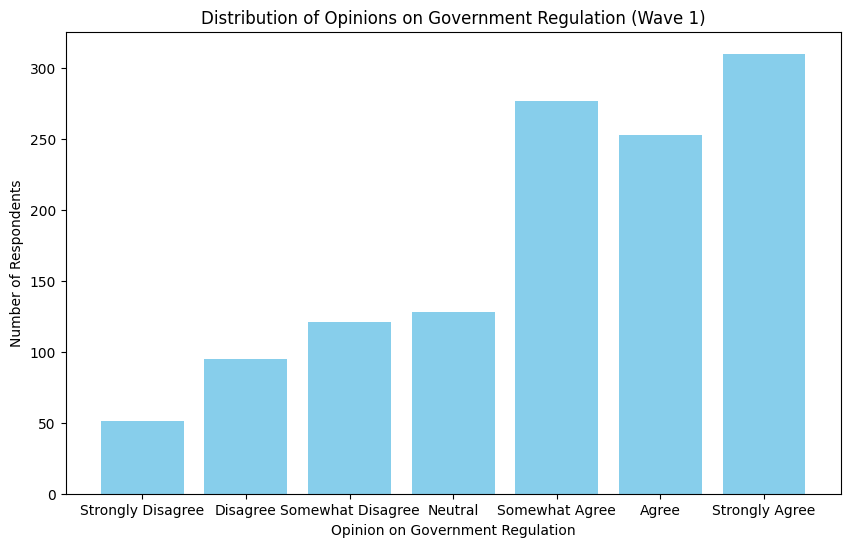

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: Bar Chart for government_should_regulate_businesses_wave_1
regulation_opinion = (
    df['government_should_regulate_businesses_wave_1'].value_counts().sort_index()
)

plt.figure(figsize=(10, 6))
plt.bar(regulation_opinion.index, regulation_opinion.values, color='skyblue')
plt.xlabel('Opinion on Government Regulation')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Opinions on Government Regulation (Wave 1)')
plt.xticks(
    ticks=regulation_opinion.index,
    labels=[
        'Strongly Disagree',
        'Disagree',
        'Somewhat Disagree',
        'Neutral',
        'Somewhat Agree',
        'Agree',
        'Strongly Agree',
    ],
)
plt.show()

In [19]:
regulation_opinion

government_should_regulate_businesses_wave_1
1.0     51
2.0     95
3.0    121
4.0    128
5.0    277
6.0    253
7.0    310
Name: count, dtype: int64

In [21]:
df["party_id_wave_1"].value_counts()

party_id_wave_1
1.0    692
2.0    530
Name: count, dtype: int64

In [3]:
import json

data = {
    "key1": ["element 1", "element 2"],
    "key2": ["another element 1", "another element 2"],
}

with open("output.json", "w") as file:
    json.dump(data, file)

In [5]:
with open("output.json", "r") as file:
    data = json.load(file)
data

{'key1': ['element 1', 'element 2'],
 'key2': ['another element 1', 'another element 2']}

In [6]:
query = "awdhada"

query[:2]

'aw'

In [7]:
with open("OKG/wikipedia/.cache/retriever_cache.json", "r") as f:
    cache = json.load(f)

print(cache)

{'Socrates#Comp': ["The Stoics relied heavily on Socrates. They applied the Socratic method as a tool to avoid inconsistencies. Their moral doctrines focused on how to live a smooth life through wisdom and virtue. The Stoics assigned virtue a crucial role in attaining happiness and also prioritized the relation between goodness and ethical excellence, all of which echoed Socratic thought. At the same time, the philosophical current of Platonism claimed Socrates as its predecessor, in ethics and in its theory of knowledge. Arcesilaus, who became the head of the Academy about 80 years after its founding by Plato, radically changed the Academy's doctrine to what is now known as Academic Skepticism, centered on the Socratic philosophy of ignorance. The Academic Skeptics competed with the Stoics over who was Socrates's true heir with regard to ethics. While the Stoics insisted on knowledge-based ethics, Arcesilaus relied on Socratic ignorance. The Stoics' reply to Arcesilaus was that Socrat

In [10]:
cache.keys()

dict_keys(['Socrates#Comp', 'Confucius#Comp', 'Roman_Empire#Comp', 'Ottoman_Empire#Comp', 'John_F._Kennedy#Comp', 'Ronald_Reagan#Comp', 'Economic_policy#Comp', 'New_Deal#Comp', 'Great_Society#Comp', 'United_States#Comp', 'Canada#Comp', 'American_Revolution#Comp', 'French_Revolution#Comp', 'Franklin_D._Roosevelt#Comp', 'Finland#Comp', 'Elon_Musk#Comp', 'Jeff_Bezos#Comp', 'Industrial_Revolution#How ', 'Internet#How ', 'Communication#How ', 'Social_media#How ', 'Technology#How ', 'Political_communication#How ', 'Education#How ', 'American_Civil_Rights_Movement#Prov', 'Nelson_Mandela#Plea', 'Cleopatra#Plea', 'Rosalind_Franklin#Plea', 'Alan_Turing#Plea', 'Ada_Lovelace#Plea', 'Computer_science#Plea', 'Galileo_Galilei#Plea', 'Astronomy#Plea', 'Leonardo_da_Vinci#Plea', 'Culture#Plea', 'Renaissance#Plea', 'Mary_Shelley#Plea', 'Winston_Churchill#Plea', 'Abraham_Lincoln#Why ', 'Emancipation_Proclamation#Why ', 'Roman_Empire#Why ', '5th_century#Why ', 'United_States#Why ', 'World_War_I#Why ', '191